In [10]:
import sys
import os
sys.path.append(os.path.abspath("../../src"))

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from time import time
import torch.nn as nn

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


def get_hankel(seq_len: int, use_hankel_L: bool = False) -> np.ndarray:
    entries = np.arange(1, seq_len + 1, dtype=np.float64)
    i_plus_j = entries[:, None] + entries[None, :]

    if use_hankel_L:
        sgn = (-1.0) ** (i_plus_j - 2.0) + 1.0
        denom = (i_plus_j + 3.0) * (i_plus_j - 1.0) * (i_plus_j + 1.0)
        Z = sgn * (8.0 / denom)
    elif not use_hankel_L:
        Z = 2.0 / (i_plus_j**3 - i_plus_j)
    else:
        raise ValueError("use_hankel_L must be a boolean")

    return Z

def get_spectral_filters(
    seq_len: int, 
    K: int, 
    use_hankel_L: bool = False, 
    device: torch.device = None,
    dtype: torch.dtype = torch.float,
) -> torch.Tensor:
    # assert torch.cuda.is_available(), "CUDA is required."
    Z = get_hankel(seq_len, use_hankel_L)
    sigma, phi = np.linalg.eigh(Z)
    sigma_k, phi_k = sigma[-K:], phi[:, -K:]
    phi_k *= sigma_k ** 0.25
    filters = torch.from_numpy(phi_k)
    return filters.to(device=device, dtype=dtype)


In [12]:
from lds_utils import exponential_decay_init

In [115]:
K = 20
seq_len = 1024
phi = get_spectral_filters(seq_len, K)

In [116]:
class VectorGen(nn.Module):
    def __init__(self, state_dim):
        super(VectorGen, self).__init__()
        self.state_dim = state_dim
        
        self.A = exponential_decay_init([state_dim], lam = 10)
        self.B = torch.randn(state_dim) / 1000
        self.C = torch.randn(state_dim) / state_dim
        # self.M = nn.Parameter(torch.randn(output_dim, input_dim, kx) / (output_dim))

    def forward(self, seq_len = 1024):
        # Initialize output tensor
        outputs = []
        
        # For each position
        for i in range(seq_len):
            # Compute A^i
            a_power = self.A ** i
            outputs.append(self.C * (a_power * self.B))
            
        return torch.stack(outputs).T #shape is [state_dim, seq_len]

In [130]:
class LDS(nn.Module):
    def __init__(self, state_dim):
        super(LDS, self).__init__()
        self.state_dim = state_dim
        
        self.A = exponential_decay_init([state_dim], lam = 15)
        self.B = torch.randn(1, state_dim) / 1000
        self.C = torch.randn(state_dim, 1) / state_dim
        # self.M = nn.Parameter(torch.randn(output_dim, input_dim, kx) / (output_dim))

    def forward(self, seq_len = 1024):
        # Initialize output tensor
        outputs = torch.zeros(seq_len)
        
        # For each position
        for i in range(seq_len):
            # Compute A^i
            a_power = self.A ** i
            
            # Multiply C[:,0] * A^i * B[i]
            outputs[i] = torch.sum(self.C[:,0] * a_power * self.B[0])
            
        return outputs


In [133]:
import tqdm
vectors = []
for i in tqdm.tqdm(range(1024)):
    # Create new LDS instance
    lds = LDS(state_dim=8192)
    # Get output sequence
    output = lds.forward(seq_len=1024)
    vectors.append(output)

# Stack into tensor of shape [1024, seq_len]
lds_vectors = torch.stack(vectors)


100%|██████████| 1024/1024 [00:55<00:00, 18.54it/s]


In [134]:
rank = torch.linalg.matrix_rank(lds_vectors)
print("Rank of vec:", rank)

Rank of vec: tensor(25)


In [126]:
vg = VectorGen(8192)
vec = vg()

In [127]:
# Generate random coefficients for 1024 combinations
random_coeffs = torch.randn(vec.shape[1], 1024) 

# Create random combinations of the basis vectors
random_vecs = vec @ random_coeffs  # Shape will be [8192, 1024]


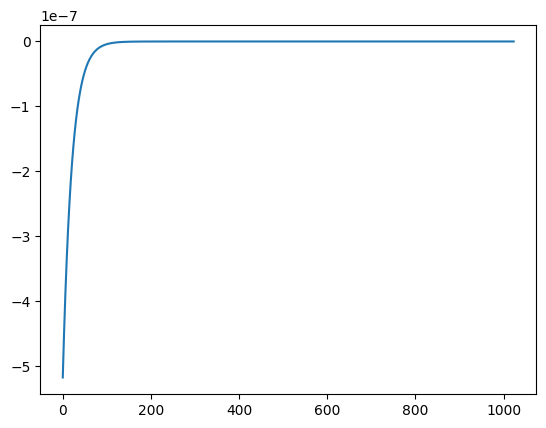

In [118]:
import matplotlib.pyplot as plt
plt.plot(vec[0])

In [119]:
from scipy.linalg import qr

In [120]:
Q, R = torch.linalg.qr(vec) 
coeffs = Q.T @ phi[:, 0]
recon_vec = Q @ coeffs

vec = QR

lds_coeffs = (torch.inverse(R) @ coeffs)

NameError: name 'QR' is not defined

In [121]:
recon_lds = vec @ lds_coeffs

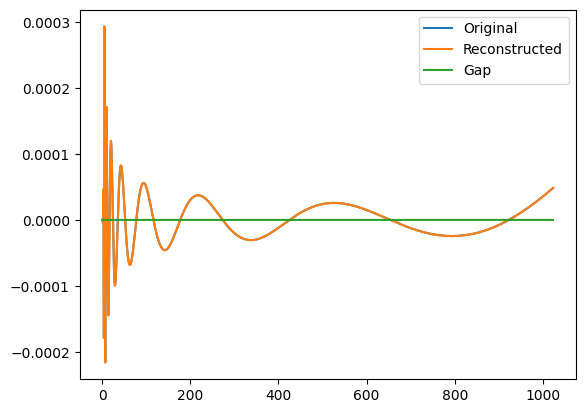

In [122]:
plt.figure()
plt.plot(phi[:,0], label='Original')
plt.plot(recon_vec, label='Reconstructed')
plt.plot(recon_vec - phi[:, 0], label = 'Gap')
# plt.plot(recon_lds, label='Reconstructed from LDS')
plt.legend()
plt.show()


In [123]:
R_inv = torch.linalg.inv(R)
q_j = vec.T @ R_inv[:, 0]
